# Setup
This IPython notebook will walk through the steps of characterizing iModulons through the semi-automated tools in PyModulon. You will need:

* M and A matrices
* Expression data (e.g. `log_tpm_norm.csv`)
* Gene table and KEGG/GO annotations (Generated in `gene_annotation.ipynb`)
* Sample table, with a column for `project` and `condition`
* TRN file

Optional:
* iModulon table (if you already have some characterized iModulons)

In [1]:
from pymodulon.core import IcaData
from pymodulon.plotting import *
from os import path
import pandas as pd
import re
from Bio.KEGG import REST
from tqdm.notebook import tqdm

In [2]:
# Enter the location of your data here
data_dir = '../example_data/processed_data/'

## Check your sample table (i.e. metadata file)
Your metadata file will probably have a lot of columns, most of which you may not care about. Feel free to save a secondary copy of your metadata file with only columns that seem relevant to you. The two most important columns are:
1. `project`
2. `condition`

Make sure that these columns exist in your metadata file

In [3]:
df_metadata = pd.read_csv(path.join(data_dir,'metadata.tsv'),index_col=0,sep='\t')
df_metadata[['project','condition']].head()

,project,condition
ERX1819430,spbeta,spbeta_nopep_20m
ERX1819431,spbeta,spbeta_pep_20m
ERX1819432,spbeta,spbeta_nopep_20m
ERX1819433,spbeta,spbeta_pep_20m
ERX1819434,spbeta,phi3T_pep_10m


In [4]:
print(df_metadata.project.notnull().all())
print(df_metadata.condition.notnull().all())

True
True


## Check your TRN

Each row of the TRN file represents a regulatory interaction.  
**Your TRN file must have the following columns:**
1. `regulator` - Name of regulator (`/` or `+` characters will be converted to `;`)
1. `gene_id` - Locus tag of gene being regulated

The following columns are optional, but are helpful to have:
1. `regulator_id` - Locus tag of regulator
1. `gene_name` - Name of gene (can automatically update this using `name2num`)
1. `direction` - Direction of regulation ('+' for activation, '-' for repression, '?' or NaN for unknown)
1. `evidence` - Evidence of regulation (e.g. ChIP-exo, qRT-PCR, SELEX, Motif search)
1. `PMID` - Reference for regulation

You may add any other columns that could help you. TRNs may be saved as either CSV or TSV files. See below for an example:

In [5]:
df_trn = pd.read_csv(path.join(data_dir,'TRN.csv'))
df_trn.head()

,regulator,gene_id,effect
0,PerR,BSU_08820,repression
1,PerR,BSU_32990,repression
2,PerR,BSU_03510,activation
3,PerR,BSU_11500,repression
4,PerR,BSU_03520,activation


The `regulator` and `gene_id` must be filled in for each row

In [6]:
print(df_trn.regulator.notnull().all())
print(df_trn.gene_id.notnull().all())

True
True


## Load the data
You're now ready to load your IcaData object!

In [7]:
ica_data = IcaData(M = path.join(data_dir,'M.csv'),
                   A = path.join(data_dir,'A.csv'),
                   X = path.join(data_dir,'log_tpm_norm.csv'),
                   gene_table = path.join(data_dir,'gene_info.csv'),
                   sample_table = path.join(data_dir,'metadata.tsv'),
                   trn = path.join(data_dir,'TRN.csv'),
                   optimize_cutoff=True)

If you don't have a TRN (or have a very minimal TRN), use `threshold_method = 'kmeans'`

In [8]:
# ica_data = IcaData(M = path.join(data_dir,'M.csv'),
#                    A = path.join(data_dir,'A.csv'),
#                    X = path.join(data_dir,'X.csv'),
#                    gene_table = path.join(data_dir,'gene_table.csv'),
#                    sample_table = path.join(data_dir,'sample_table.csv'),
#                    trn = path.join(data_dir,'TRN.tsv'),
#                    threshold_method = 'kmeans')

# Regulatory iModulons
Use `compute_trn_enrichment` to automatically check for Regulatory iModulons. The more complete your TRN, the more regulatory iModulons you'll find.

In [9]:
ica_data.compute_trn_enrichment()

,imodulon,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
0,0,S-box,1.436720e-30,8.620321e-30,0.652174,0.576923,0.612245,15.0,26.0,23.0,1.0
1,0,ThrR,5.239175e-07,1.571752e-06,0.130435,0.750000,0.222222,3.0,4.0,23.0,1.0
2,2,WalR,1.897147e-12,2.656006e-11,0.388889,0.291667,0.333333,7.0,24.0,18.0,1.0
3,2,RemA,8.460083e-12,5.922058e-11,0.388889,0.241379,0.297872,7.0,29.0,18.0,1.0
4,2,OpcR,1.456062e-08,6.794954e-08,0.222222,0.500000,0.307692,4.0,8.0,18.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
124,66,AbrB,2.100153e-07,7.875574e-07,0.375000,0.044280,0.079208,12.0,271.0,32.0,1.0
125,66,IolR,1.685319e-06,4.213298e-06,0.125000,0.307692,0.177778,4.0,13.0,32.0,1.0
126,66,LicR,1.465024e-06,4.213298e-06,0.093750,0.750000,0.166667,3.0,4.0,32.0,1.0
127,67,KipR,6.440803e-21,3.220402e-20,0.777778,1.000000,0.875000,7.0,7.0,9.0,1.0


You can also search for AND/OR combinations of regulators using the `max_regs` argument.

Regulator enrichments can be directly saved to the `imodulon_table` using the `save` argument. This saves the enrichment with the lowest q-value to the table.

In [10]:
# First search for regulator enrichments with 2 regulators
ica_data.compute_trn_enrichment(max_regs=2,save=True)

# Next, search for regulator enrichments with just one regulator. This will supercede the 2 regulator enrichments.
ica_data.compute_trn_enrichment(max_regs=1,save=True)

,imodulon,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
0,0,S-box,1.436720e-30,8.620321e-30,0.652174,0.576923,0.612245,15.0,26.0,23.0,1.0
1,0,ThrR,5.239175e-07,1.571752e-06,0.130435,0.750000,0.222222,3.0,4.0,23.0,1.0
2,2,WalR,1.897147e-12,2.656006e-11,0.388889,0.291667,0.333333,7.0,24.0,18.0,1.0
3,2,RemA,8.460083e-12,5.922058e-11,0.388889,0.241379,0.297872,7.0,29.0,18.0,1.0
4,2,OpcR,1.456062e-08,6.794954e-08,0.222222,0.500000,0.307692,4.0,8.0,18.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
124,66,AbrB,2.100153e-07,7.875574e-07,0.375000,0.044280,0.079208,12.0,271.0,32.0,1.0
125,66,IolR,1.685319e-06,4.213298e-06,0.125000,0.307692,0.177778,4.0,13.0,32.0,1.0
126,66,LicR,1.465024e-06,4.213298e-06,0.093750,0.750000,0.166667,3.0,4.0,32.0,1.0
127,67,KipR,6.440803e-21,3.220402e-20,0.777778,1.000000,0.875000,7.0,7.0,9.0,1.0


The list of regulatory iModulons are shown below

In [11]:
regulatory_imodulons = ica_data.imodulon_table[ica_data.imodulon_table.regulator.notnull()]
print(len(ica_data.imodulon_table),'Total iModulons')
print(len(regulatory_imodulons),'Regulatory iModulons')
regulatory_imodulons

72 Total iModulons
53 Regulatory iModulons


,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
0,S-box,1.436720e-30,8.620321e-30,0.652174,0.576923,0.612245,15.0,26.0,23.0,1.0
2,WalR,1.897147e-12,2.656006e-11,0.388889,0.291667,0.333333,7.0,24.0,18.0,1.0
4,Rex,1.416977e-19,7.084883e-19,1.000000,0.583333,0.736842,7.0,12.0,7.0,1.0
5,Fnr,1.066741e-14,6.400444e-14,0.600000,0.545455,0.571429,6.0,11.0,10.0,1.0
8,CsoR/Fnr,1.842216e-11,8.719391e-07,0.113636,0.400000,0.176991,10.0,25.0,88.0,2.0
10,SigM,1.614855e-27,2.099311e-26,0.894737,0.182796,0.303571,17.0,93.0,19.0,1.0
11,EAR riboswitch,3.154667e-40,2.208267e-39,0.833333,1.000000,0.909091,15.0,15.0,18.0,1.0
12,SigB,4.367180e-66,6.987488e-65,0.962264,0.230769,0.372263,51.0,221.0,53.0,1.0
13,PyrR,6.910434e-27,1.382087e-26,1.000000,0.900000,0.947368,9.0,10.0,9.0,1.0
14,SigV,2.324641e-12,3.022033e-11,0.333333,0.333333,0.333333,7.0,21.0,21.0,1.0


You can rename iModulons in this jupyter notebook, or you can save the iModulon table as a CSV and edit it in Excel.

If two iModulons have the same regulator (e.g. 'Reg'), they will be named 'Reg-1' and 'Reg-2'

In [12]:
ica_data.rename_imodulons(regulatory_imodulons.regulator.to_dict())
ica_data.imodulon_table.head()

,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
S-box,S-box,1.436720e-30,8.620321e-30,0.652174,0.576923,0.612245,15.0,26.0,23.0,1.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WalR,WalR,1.897147e-12,2.656006e-11,0.388889,0.291667,0.333333,7.0,24.0,18.0,1.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rex,Rex,1.416977e-19,7.084883e-19,1.000000,0.583333,0.736842,7.0,12.0,7.0,1.0


In [13]:
regulatory_imodulons = ica_data.imodulon_table[ica_data.imodulon_table.regulator.notnull()]

# Functional iModulons

## GO Enrichments

First load the Gene Ontology annotations

In [14]:
DF_GO = pd.read_csv(path.join(data_dir,'GO_annotations.csv'),index_col=0)
DF_GO.head()

,gene_id,gene_name,gene_ontology
0,BSU_16390,flhA,plasma membrane
1,BSU_16390,flhA,bacterial-type flagellum assembly
2,BSU_09270,glpP,"transcription antitermination factor activity,..."
3,BSU_01420,rpsK,translation
4,BSU_01420,rpsK,small ribosomal subunit rRNA binding


The `GO_annotations.csv` file was created from `gene_annotation.ipynb`.

In [15]:
DF_GO_enrich = ica_data.compute_annotation_enrichment(DF_GO,'gene_ontology')

In [16]:
DF_GO_enrich.head()

,imodulon,gene_ontology,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
0,S-box,L-methionine salvage from methylthioadenosine,0.000027,0.014436,0.086957,1.000000,0.160000,2.0,2.0,23.0
1,S-box,L-serine biosynthetic process,0.000081,0.014436,0.086957,0.666667,0.153846,2.0,3.0,23.0
2,S-box,carbon-sulfur lyase activity,0.000081,0.014436,0.086957,0.666667,0.153846,2.0,3.0,23.0
3,S-box,cystathionine gamma-lyase activity,0.000081,0.014436,0.086957,0.666667,0.153846,2.0,4.0,23.0
4,S-box,cysteine biosynthetic process via cystathionine,0.000081,0.014436,0.086957,0.666667,0.153846,2.0,3.0,23.0


In [17]:
DF_GO_enrich.to_csv(path.join(data_dir,'GO_enrichments.csv'))

## KEGG Enrichments

### Load KEGG mapping
The `kegg_mapping.csv` file was created from `gene_annotation.ipynb`. This contains KEGG orthologies, pathways, modules, and reactions. Only pathways and modules are relevant to iModulon characterization.

In [18]:
DF_KEGG = pd.read_csv(path.join(data_dir,'kegg_mapping.csv'),index_col=0)
print(DF_KEGG.database.unique())
DF_KEGG.head()

['KEGG_pathway' 'KEGG_module' 'KEGG_reaction']


,gene_id,database,kegg_id
2553,BSU_00010,KEGG_pathway,map02020
2554,BSU_00010,KEGG_pathway,map04112
2561,BSU_00020,KEGG_pathway,map00230
2562,BSU_00020,KEGG_pathway,map00240
2563,BSU_00020,KEGG_pathway,map01100


In [19]:
kegg_pathways = DF_KEGG[DF_KEGG.database == 'KEGG_pathway']
kegg_modules = DF_KEGG[DF_KEGG.database == 'KEGG_module']

### Perform enrichment
Uses the `compute_annotation_enrichment` function

In [20]:
DF_pathway_enrich = ica_data.compute_annotation_enrichment(kegg_pathways,'kegg_id')
DF_module_enrich = ica_data.compute_annotation_enrichment(kegg_modules,'kegg_id')

In [21]:
DF_pathway_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
0,S-box,map00270,2.667203e-21,6.001206e-19,0.565217,0.288889,0.382353,13.0,45.0,23.0
1,S-box,map01100,2.165849e-10,2.436580e-08,0.739130,0.026941,0.051988,17.0,631.0,23.0
2,S-box,map01230,3.947294e-09,2.960471e-07,0.391304,0.075630,0.126761,9.0,119.0,23.0
3,S-box,map00450,1.958203e-07,1.101489e-05,0.173913,0.363636,0.235294,4.0,11.0,23.0
4,S-box,map00260,7.820536e-07,3.519241e-05,0.217391,0.142857,0.172414,5.0,35.0,23.0


In [22]:
DF_module_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
0,S-box,M00034,1.428739e-14,3.843308e-12,0.304348,0.636364,0.411765,7.0,11.0,23.0
1,S-box,M00017,1.210051e-09,1.627518e-07,0.217391,0.454545,0.294118,5.0,11.0,23.0
2,S-box,M00018,7.233560e-06,6.486092e-04,0.130435,0.375000,0.193548,3.0,8.0,23.0
3,S-box,M00020,8.090796e-05,5.441060e-03,0.086957,0.666667,0.153846,2.0,3.0,23.0
4,WalR,M00209,1.456062e-08,3.916806e-06,0.222222,0.500000,0.307692,4.0,8.0,18.0


### Convert KEGG IDs to human-readable names

In [23]:
for idx,key in tqdm(DF_pathway_enrich.kegg_id.items(),total=len(DF_pathway_enrich)):
    text = REST.kegg_find('pathway',key).read()
    try:
        name = re.search('\t(.*)\n',text).group(1)
        DF_pathway_enrich.loc[idx,'pathway_name'] = name
    except AttributeError:
        DF_pathway_enrich.loc[idx,'pathway_name'] = None
    
for idx,key in tqdm(DF_module_enrich.kegg_id.items(),total=len(DF_module_enrich)):
    text = REST.kegg_find('module',key).read()
    try:
        name = re.search('\t(.*)\n',text).group(1)
        DF_module_enrich.loc[idx,'module_name'] = name
    except AttributeError:
        DF_module_enrich.loc[idx,'module_name'] = None

In [24]:
DF_pathway_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
0,S-box,map00270,2.667203e-21,6.001206e-19,0.565217,0.288889,0.382353,13.0,45.0,23.0,Cysteine and methionine metabolism
1,S-box,map01100,2.165849e-10,2.436580e-08,0.739130,0.026941,0.051988,17.0,631.0,23.0,Metabolic pathways
2,S-box,map01230,3.947294e-09,2.960471e-07,0.391304,0.075630,0.126761,9.0,119.0,23.0,Biosynthesis of amino acids
3,S-box,map00450,1.958203e-07,1.101489e-05,0.173913,0.363636,0.235294,4.0,11.0,23.0,Selenocompound metabolism
4,S-box,map00260,7.820536e-07,3.519241e-05,0.217391,0.142857,0.172414,5.0,35.0,23.0,"Glycine, serine and threonine metabolism"


In [25]:
DF_module_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
0,S-box,M00034,1.428739e-14,3.843308e-12,0.304348,0.636364,0.411765,7.0,11.0,23.0,Methionine salvage pathway
1,S-box,M00017,1.210051e-09,1.627518e-07,0.217391,0.454545,0.294118,5.0,11.0,23.0,"Methionine biosynthesis, aspartate => homoseri..."
2,S-box,M00018,7.233560e-06,6.486092e-04,0.130435,0.375000,0.193548,3.0,8.0,23.0,"Threonine biosynthesis, aspartate => homoserin..."
3,S-box,M00020,8.090796e-05,5.441060e-03,0.086957,0.666667,0.153846,2.0,3.0,23.0,"Serine biosynthesis, glycerate-3P => serine"
4,WalR,M00209,1.456062e-08,3.916806e-06,0.222222,0.500000,0.307692,4.0,8.0,18.0,None


### Save files

In [26]:
DF_pathway_enrich.to_csv(path.join(data_dir,'kegg_pathway_enrichments.csv'))
DF_pathway_enrich.to_csv(path.join(data_dir,'kegg_module_enrichments.csv'))

# Check for single gene iModulons

Some iModulons are dominated by a single, high-coefficient gene. These iModulons may result from:
1. Overdecomposition of the dataset to identify noisy genes
1. Artificial knock-out of single genes
1. Regulons with only one target gene

No matter what causes these iModulons, it is important to be aware of them. The find_single_gene_imodulons function identifies iModulons that are likely dominated by a single gene.

The iModulons identified by ``find_single_gene_imodulons`` may contain more than one gene, since a threshold-agnostic method is used to identify these iModulons.

In [48]:
sg_imods = ica_data.find_single_gene_imodulons(save=True)
len(sg_imods)

5

In [28]:
for i,mod in enumerate(sg_imods):
    ica_data.rename_imodulons({mod:'SG_'+str(i+1)})

In [29]:
ica_data.imodulon_table[ica_data.imodulon_table.single_gene == True]

,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs,single_gene
SG_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
SG_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
SG_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
SG_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
SG_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [30]:
ica_data.view_imodulon('SG_1')

,gene_weight,gene_name,accession,old_locus_tag,start,end,strand,gene_product,COG,uniprot,operon,regulator
BSU_24620,0.519729,tasA,AL009126.3,BSU24620,2553081,2553866,-,major biofilm matrix component,Function unknown,P54507,Op1955,"SigA,SinR,RemA,AbrB,LutR"


# Compute explained variance

In [34]:
from pymodulon.util import explained_variance

In [42]:
explained_variance(ica_data)

0.6716695992147558

In [37]:
rec_var = {}
for k in ica_data.imodulon_names:
    rec_var[k] = explained_variance(ica_data,imodulons=[k])
df_rec_var = pd.Series(rec_var)
df_rec_var = df_rec_var.sort_values(ascending=False)
df_rec_var.head(10)

SigE                  0.090713
SigK                  0.026508
stringent response    0.025894
AbrB                  0.024879
Xpf                   0.024477
SigD                  0.021726
RhgR                  0.019527
CsoR/Fnr              0.018237
Fur                   0.017337
SwrA                  0.016596
dtype: float64

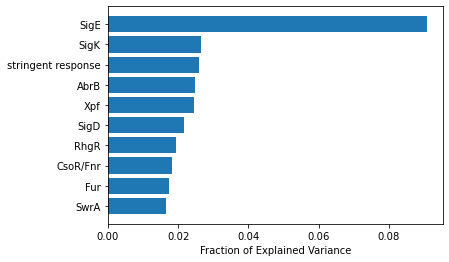

In [41]:
plt.barh(range(10,0,-1),df_rec_var.head(10),tick_label = df_rec_var.head(10).index)
plt.xlabel('Fraction of Explained Variance')
plt.yticks(range(10,0,-1));

In [53]:
reg_imodulons = ica_data.imodulon_table[ica_data.imodulon_table.regulator.notnull()].index
sg_imodulons = ica_data.imodulon_table[ica_data.imodulon_table.single_gene.notnull()].index

In [54]:
reg_ev = explained_variance(ica_data, imodulons=reg_imodulons)
sg_ev = explained_variance(ica_data, imodulons=sg_imodulons)
print('Variance explained by regulatory iModulons: {:.2f}'.format(reg_ev))
print('Variance explained by single-gene iModulons: {:.2f}'.format(sg_ev))

Variance explained by regulatory iModulons: 0.60
Variance explained by single-gene iModulons: 0.01


# Save iModulon object

In [31]:
from pymodulon.io import *

This will save your iModulon table, your thresholds, and any other information stored in the ica_data object.

In [32]:
save_to_json(ica_data, path.join('..','example_data','processed_data','bsu.json.gz'))

If you prefer to view and edit your iModulon table in excel, save it as a CSV and reload the iModulon as before

In [33]:
ica_data.imodulon_table.to_csv(path.join('..','example_data','processed_data','imodulon_table.csv'))